In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import optimize
from scipy import ndimage as ndi
from skimage import filters
from skimage import io, img_as_float, img_as_uint
from skimage.feature import blob_dog, peak_local_max
from skimage.measure import regionprops, label
from skimage.morphology import disk, watershed
from skimage.segmentation import clear_border

# 2D Gaussian Models for PSF
This is are the models that are fitted to individual spot instensity data

$$ PSF(x,y) = \frac{1}{2\pi\sigma_g^2}e^{-\frac{(x-x_c)^2+(y-y_c)^2}{2\sigma_g^2}} $$

$$ \mu_k = I_0 \int_{A_k}PSF(u,v)dudv + b $$

where $I_0$ is the peak intensity, $x_c$ and $y_c$ are the coordinates of the emitter, $b$ is the background intensity and $\sigma_g$ is the width of the PSF.

In [3]:
def ggaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters.
    Adapted from http://wiki.scipy.org/Cookbook/FittingData

    Parameters
    ----------
    height: float
            Peak height of Gaussian curve
    center_x: float
              X coordinate of center of the Gaussian curve
    center_y: float
              Y coordinate of the center of the Gaussian curve
    width_x: float
             Width in X of the Gaussian curve
    width_y: float
             Width in Y of the Gaussian curve

    Returns
    -------
    gauss: function
           Gaussian function that return the amplitude for a given x and y
           coordinate
    """
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x, y: height*np.exp(-(((center_x-x)/width_x)**2 +
                                      ((center_y-y)/width_y)**2)/2)


def gaussian_reig(height, cx, cy, sigma, b):
    """Returns a gaussian function with the given parameters.
    Adapted from http://wiki.scipy.org/Cookbook/FittingData

    Parameters
    ----------
    height: float
            Peak height of Gaussian curve
    center_x: float
              X coordinate of center of the Gaussian curve
    center_y: float
              Y coordinate of the center of the Gaussian curve
    width_x: float
             Width in X of the Gaussian curve
    width_y: float
             Width in Y of the Gaussian curve

    Returns
    -------
    gauss: function
           Gaussian function that return the amplitude for a given x and y
           coordinate
    """
    def gpsf(x, y, cx, cy, s):
        return (1/(2 * np.pi * s**2)) * np.exp(-((x-cx)**2 + (y-cy)**2) / (2*s**2))
    return lambda x, y: height * gpsf(x, y, cx, cy, sigma) + b


def gaussian(height, center_x, center_y, sigma, bkgd):
    """Returns a gaussian function with the given parameters.
    Adapted from http://wiki.scipy.org/Cookbook/FittingData

    Parameters
    ----------
    height: float
            Peak height of Gaussian curve
    center_x: float
              X coordinate of center of the Gaussian curve
    center_y: float
              Y coordinate of the center of the Gaussian curve
    width_x: float
             Width in X of the Gaussian curve
    width_y: float
             Width in Y of the Gaussian curve

    Returns
    -------
    gauss: function
           Gaussian function that return the amplitude for a given x and y
           coordinate
    """
    return lambda x, y: height * np.exp(-((x-center_x)**2 + (y-center_y)**2)/
                                   (2*sigma**2)) + bkgd


def moments(data):
    """Estimates the height, center_x, center_y, width_x, width_y
    gaussian parameters of a 2D distribution by calculating its
    moments.

    Parameters
    ----------
    data: ndarray
          2D array of image intensity data

    Returns
    -------
    height, height, center_x, center_y, width_x, width_y: float
    """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    width = (width_x + width_y)/2
    height = data.max()
    bkgd = data.min()
    return height, x, y, width, bkgd


def fitgaussian(data, params=None):
    """Estimates height, center_x, center_y, width_x, width_y
    gaussian parameters of a 2D Gaussian distribution by
    least squares fit.

    Parameters
    ----------
    data: ndarray
          2D array of image intensity data
    params: (float, float, float, float, float)
            (Optional) Tuple of best guess starting params for
            height, center_x, center_y, width_x, width_y to best
            optimized. If not provided, these will be estimated from
            the image data.
    """
    if not np.all(params):
        params = moments(data)

    def errorfunction(p):
        return np.ravel(gaussian(*p)(*np.indices(data.shape)) - data)
    p, success = optimize.leastsq(errorfunction, params)
    return p


def fitreig(data, params=None):
    """Estimates height, center_x, center_y, width_x, width_y
    gaussian parameters of a 2D Gaussian distribution by
    least squares fit.

    Parameters
    ----------
    data: ndarray
          2D array of image intensity data
    params: (float, float, float, float, float)
            (Optional) Tuple of best guess starting params for
            height, center_x, center_y, width_x, width_y to best
            optimized. If not provided, these will be estimated from
            the image data.
    """
    if not np.all(params):
        params = moments(data)

    def errorfunction(p):
        return np.ravel(gaussian_reig(*p)(*np.indices(data.shape)) - data)
    p, cov, infodict, success, ier = optimize.leastsq(errorfunction, params, full_output=True)
    return p, infodict

In [4]:
a = io.imread("assets/images/bama_1147.tif", as_grey=True)
c = io.imread("assets/images/bamc.tif", as_grey=True)
a_zoy = 34
a_zox = 60
a_zh = 20
a_zw = 20
c_zoy = 122
c_zox = 2
c_zh = 20
c_zw = 20

In [11]:
a.shape

(162, 127)

/Users/skeith/.virtualenvs/mmi_srm/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warnings.warn("Low image dynamic range; displaying image with "


(-0.5, 126.5, 161.5, -0.5)

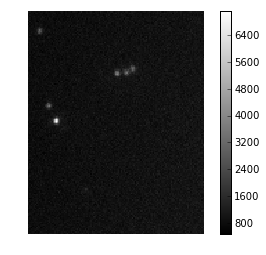

In [5]:
%matplotlib inline
im_plt = io.imshow(a, cmap="gray")
im_plt.axes.axis("off")

## Threshold segmentation

In [34]:
a_thresh = filters.threshold_otsu(a)
a_bin = a > a_thresh

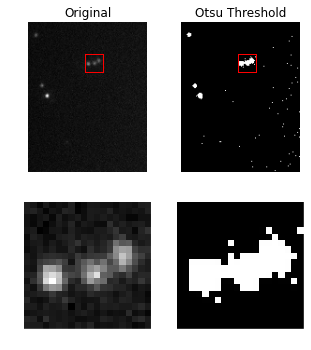

In [33]:
fig_seg_plt, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)
ax0.set_title("Original")
ax0.imshow(a, cmap=plt.cm.gray)
ax0.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax1.set_title("Otsu Threshold")
ax1.imshow(a_bin, cmap=plt.cm.gray)
ax1.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))

ax2.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax3.imshow(a_bin[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")

for ax in fig_seg_plt.axes:
    ax.set_axis_off()

fig_seg_plt.set_size_inches(4.4, 5)
plt.tight_layout()

# fig_seg_plt.savefig("assets/images/bama_seg_hsnr.png", dpi=150, transparent=True, bbox_inches="tight")

In [9]:
c_thresh_otsu = filters.threshold_otsu(c)
c_thresh = filters.threshold_yen(c)
c_bin_otsu = c > c_thresh_otsu
c_bin  = c > c_thresh

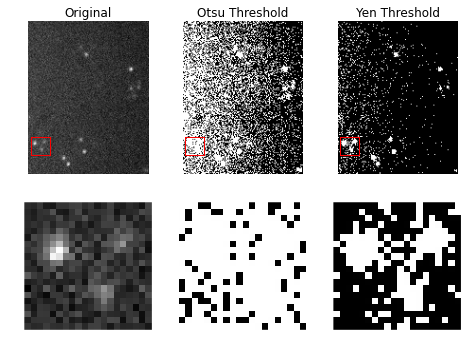

In [10]:
fig_segc_plt, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(nrows=2, ncols=3)
ax0.set_title("Original")
ax0.imshow(c, cmap=plt.cm.gray)
ax0.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax1.set_title("Otsu Threshold")
ax1.imshow(c_bin_otsu, cmap=plt.cm.gray)
ax1.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax2.set_title("Yen Threshold")
ax2.imshow(c_bin, cmap=plt.cm.gray)
ax2.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))

ax3.imshow(c[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none")
ax4.imshow(c_bin_otsu[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none")
ax5.imshow(c_bin[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none")

for ax in fig_segc_plt.axes:
    ax.set_axis_off()

fig_segc_plt.set_size_inches(6.6, 5)
plt.tight_layout()

fig_segc_plt.savefig("assets/images/bamc_seg_lsnr.png", dpi=150, transparent=True, bbox_inches="tight")

## Gaussian Filter

In [11]:
a_g1 = filters.gaussian_filter(a, sigma=1)
a_g15 = filters.gaussian_filter(a, sigma=1.5)
a_g2 = filters.gaussian_filter(a, sigma=2)
a_g5 = filters.gaussian_filter(a, sigma=5)

a_g1_thresh = filters.threshold_otsu(a_g1)
a_g1_bin = a_g1 > a_g1_thresh

In [244]:
a_g1_thresh

0.023316051646558936

In [12]:
af = img_as_float(a)

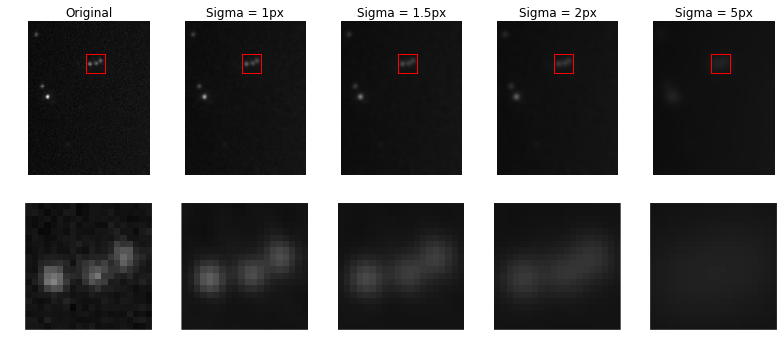

In [13]:
img_gfilt_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Original")
ax0.axis("off")
ax0.imshow(a, cmap="gray", vmin=np.min(a), vmax=np.max(a))
ax0.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax1.set_title("Sigma = 1px")
ax1.axis("off")
ax1.imshow(a_g1, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax1.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax2.set_title("Sigma = 1.5px")
ax2.axis("off")
ax2.imshow(a_g15, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax2.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax3.set_title("Sigma = 2px")
ax3.axis("off")
ax3.imshow(a_g2, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax3.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax4.set_title("Sigma = 5px")
ax4.axis("off")
ax4.imshow(a_g5, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax4.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax5.axis("off")
ax5.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(a), vmax=np.max(a))
ax6.axis("off")
ax6.imshow(a_g1[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(af), vmax=np.max(af))
ax7.axis("off")
ax7.imshow(a_g15[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(af), vmax=np.max(af))
ax8.axis("off")
ax8.imshow(a_g2[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(af), vmax=np.max(af))
ax9.axis("off")
ax9.imshow(a_g5[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(af), vmax=np.max(af))

img_gfilt_plt.set_size_inches(11, 5)
img_gfilt_plt.tight_layout()
# img_gfilt_plt.savefig("assets/images/bama_gfilt_plt.png", dpi=150, transparent=True, bbox_inches="tight")

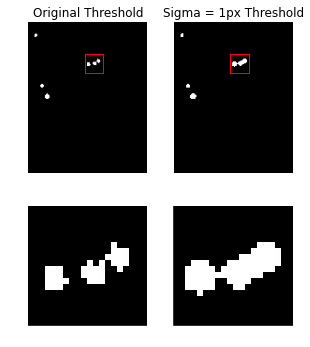

In [14]:
fig_a_ag1_bin, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
ax1.set_title("Original Threshold")
ax1.imshow(a_bin, cmap=plt.cm.gray)
ax1.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax2.set_title("Sigma = 1px Threshold")
ax2.imshow(a_g1_bin, cmap=plt.cm.gray)
ax2.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))

ax3.imshow(a_bin[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax4.imshow(a_g1_bin[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")

for ax in fig_a_ag1_bin.axes:
    ax.set_axis_off()

fig_a_ag1_bin.set_size_inches(4.4, 5)
plt.tight_layout()

# fig_a_ag1_bin.savefig("assets/images/bama_gfilt_seg.png", dpi=150, transparent=True, bbox_inches="tight")

In [15]:
c_g1 = filters.gaussian_filter(c, sigma=1)
c_g15 = filters.gaussian_filter(c, sigma=1.5)
c_g2 = filters.gaussian_filter(c, sigma=2)
c_g5 = filters.gaussian_filter(c, sigma=5)

c_g1_thresh = filters.threshold_yen(c_g1)
c_g1_bin = c_g1 > c_g1_thresh

In [16]:
cf = img_as_float(c)

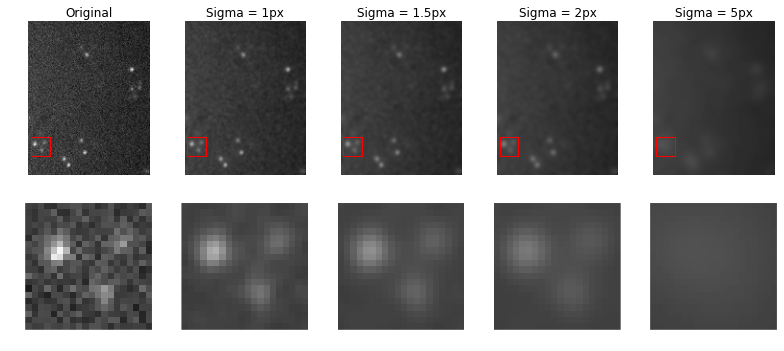

In [17]:
c_gfilt_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Original")
ax0.axis("off")
ax0.imshow(c, cmap="gray", vmin=np.min(c), vmax=np.max(c))
ax0.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax1.set_title("Sigma = 1px")
ax1.axis("off")
ax1.imshow(c_g1, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax1.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax2.set_title("Sigma = 1.5px")
ax2.axis("off")
ax2.imshow(c_g15, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax2.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax3.set_title("Sigma = 2px")
ax3.axis("off")
ax3.imshow(c_g2, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax3.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax4.set_title("Sigma = 5px")
ax4.axis("off")
ax4.imshow(c_g5, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax4.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax5.axis("off")
ax5.imshow(c[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(c), vmax=np.max(c))
ax6.axis("off")
ax6.imshow(c_g1[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(cf), vmax=np.max(cf))
ax7.axis("off")
ax7.imshow(c_g15[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(cf), vmax=np.max(cf))
ax8.axis("off")
ax8.imshow(c_g2[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(cf), vmax=np.max(cf))
ax9.axis("off")
ax9.imshow(c_g5[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(cf), vmax=np.max(cf))

c_gfilt_plt.set_size_inches(11, 5)
c_gfilt_plt.tight_layout()
# c_gfilt_plt.savefig("assets/images/bamc_gfilt_plt.png", dpi=150, transparent=True, bbox_inches="tight")

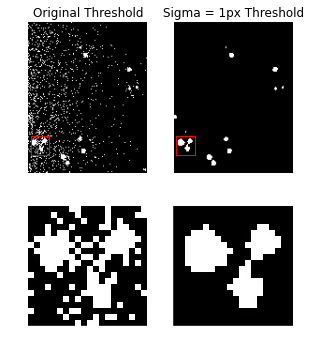

In [18]:
fig_c_cg1_bin, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
ax1.set_title("Original Threshold")
ax1.imshow(c_bin, cmap=plt.cm.gray)
ax1.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax2.set_title("Sigma = 1px Threshold")
ax2.imshow(c_g1_bin, cmap=plt.cm.gray)
ax2.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))

ax3.imshow(c_bin[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none")
ax4.imshow(c_g1_bin[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none")

for ax in fig_c_cg1_bin.axes:
    ax.set_axis_off()

fig_c_cg1_bin.set_size_inches(4.4, 5)
plt.tight_layout()
# fig_c_cg1_bin.savefig("assets/images/bamc_gfilt_seg.png", dpi=150, transparent=True, bbox_inches="tight")

## Median Filter

In [19]:
a_m1 = img_as_float(filters.median(a, disk(1)))
a_m15 = img_as_float(filters.median(a, disk(1.5)))
a_m2 = img_as_float(filters.median(a, disk(2)))
a_m5 = img_as_float(filters.median(a, disk(5)))

/Users/skeith/.virtualenvs/mmi_srm/lib/python2.7/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 12 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


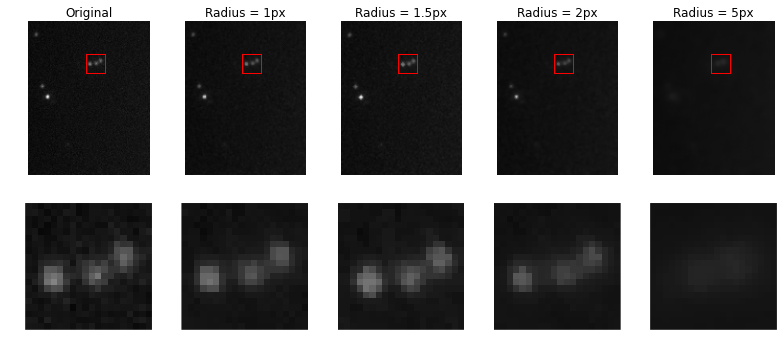

In [20]:
img_mfilt_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Original")
ax0.axis("off")
ax0.imshow(a, cmap="gray", vmin=np.min(a), vmax=np.max(a))
ax0.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax1.set_title("Radius = 1px")
ax1.axis("off")
ax1.imshow(a_m1, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax1.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax2.set_title("Radius = 1.5px")
ax2.axis("off")
ax2.imshow(a_m15, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax2.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax3.set_title("Radius = 2px")
ax3.axis("off")
ax3.imshow(a_m2, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax3.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax4.set_title("Radius = 5px")
ax4.axis("off")
ax4.imshow(a_m5, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax4.add_patch(Rectangle((a_zox, a_zoy), a_zw, a_zh, edgecolor='red', fill=False))
ax5.axis("off")
ax5.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(a), vmax=np.max(a))
ax6.axis("off")
ax6.imshow(a_m1[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(af), vmax=np.max(af))
ax7.axis("off")
ax7.imshow(a_m15[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(af), vmax=np.max(af))
ax8.axis("off")
ax8.imshow(a_m2[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(af), vmax=np.max(af))
ax9.axis("off")
ax9.imshow(a_m5[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap="gray", interpolation="none", vmin=np.min(af), vmax=np.max(af))
img_mfilt_plt.set_size_inches(11, 5)
img_mfilt_plt.tight_layout()
# img_mfilt_plt.savefig("assets/images/bama_mfilt_plt.png", dpi=150, transparent=True, bbox_inches="tight")

In [21]:
c_m1 = img_as_float(filters.median(c, disk(1)))
c_m15 = img_as_float(filters.median(c, disk(1.5)))
c_m2 = img_as_float(filters.median(c, disk(2)))
c_m5 = img_as_float(filters.median(c, disk(5)))

/Users/skeith/.virtualenvs/mmi_srm/lib/python2.7/site-packages/skimage/filters/rank/generic.py:68: UserWarning: Bitdepth of 11 may result in bad rank filter performance due to large number of bins.
  "performance due to large number of bins." % bitdepth)


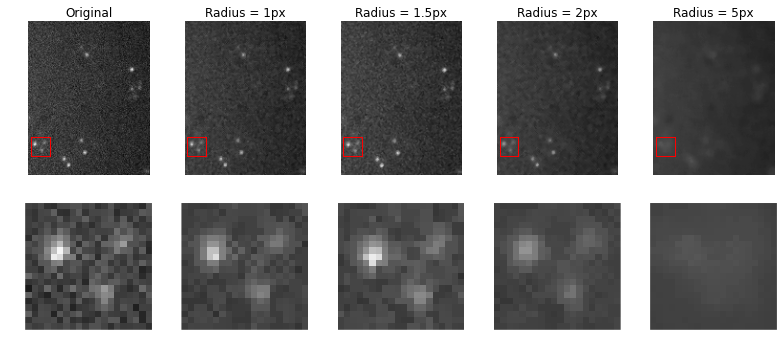

In [342]:
c_mfilt_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Original")
ax0.axis("off")
ax0.imshow(c, cmap="gray", vmin=np.min(c), vmax=np.max(c))
ax0.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax1.set_title("Radius = 1px")
ax1.axis("off")
ax1.imshow(c_m1, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax1.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax2.set_title("Radius = 1.5px")
ax2.axis("off")
ax2.imshow(c_m15, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax2.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax3.set_title("Radius = 2px")
ax3.axis("off")
ax3.imshow(c_m2, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax3.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax4.set_title("Radius = 5px")
ax4.axis("off")
ax4.imshow(c_m5, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax4.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax5.axis("off")
ax5.imshow(c[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(c), vmax=np.max(c))
ax6.axis("off")
ax6.imshow(c_m1[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(cf), vmax=np.max(cf))
ax7.axis("off")
ax7.imshow(c_m15[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(cf), vmax=np.max(cf))
ax8.axis("off")
ax8.imshow(c_m2[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(cf), vmax=np.max(cf))
ax9.axis("off")
ax9.imshow(c_m5[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap="gray", interpolation="none", vmin=np.min(cf), vmax=np.max(cf))

c_mfilt_plt.set_size_inches(11, 5)
c_mfilt_plt.tight_layout()
# c_mfilt_plt.savefig("assets/images/bamc_mfilt_plt.png", dpi=150, transparent=True, bbox_inches="tight")

## Difference of Gaussian

In [22]:
a_g1 = filters.gaussian_filter(a, sigma=1)
a_g16 = filters.gaussian_filter(a, sigma=1.6)
a_dog = np.subtract(a_g1, a_g16)
a_dog_thresh = filters.threshold_yen(a_dog)
a_dog_bin = a_dog > a_dog_thresh

In [51]:
# Labels
a_dog_labels = label(clear_border(a_dog_bin), connectivity=2)
a_dog_props = regionprops(a_dog_labels, intensity_image=a)

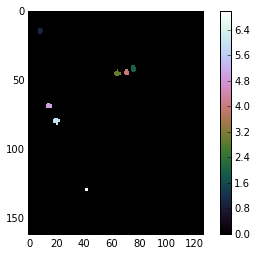

In [52]:
io.imshow(a_dog_labels)

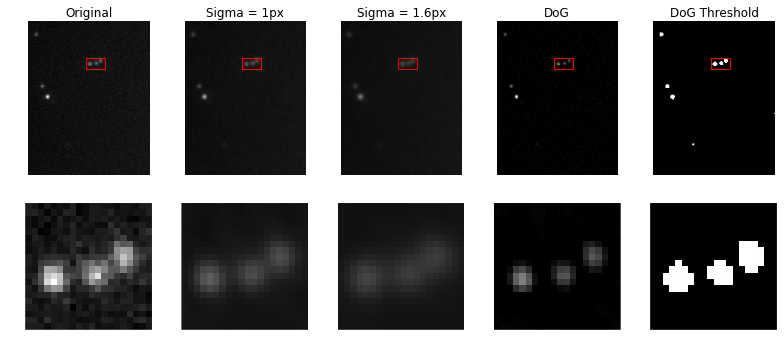

In [23]:
img_dog_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Original")
ax0.imshow(a, cmap="gray")
ax0.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax1.set_title("Sigma = 1px")
ax1.imshow(a_g1, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax1.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax2.set_title("Sigma = 1.6px")
ax2.imshow(a_g16, cmap="gray", vmin=np.min(af), vmax=np.max(af))
ax2.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax3.set_title("DoG")
ax3.imshow(a_dog, cmap="gray", vmin=0, vmax=0.02)
ax3.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))
ax4.set_title("DoG Threshold")
ax4.imshow(a_dog_bin, cmap="gray")
ax4.add_patch(Rectangle((60, 38), 20, 12, edgecolor='red', fill=False))

ax5.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax6.imshow(a_g1[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none", vmin=np.min(af), vmax=np.max(af))
ax7.imshow(a_g16[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none", vmin=np.min(af), vmax=np.max(af))
ax8.imshow(a_dog[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none", vmin=0, vmax=0.02)
ax9.imshow(a_dog_bin[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")

for ax in img_dog_plt.axes:
    ax.set_axis_off()

img_dog_plt.set_size_inches(11, 5)
plt.tight_layout()
# img_dog_plt.savefig("assets/images/img_dog_plt.png", dpi=150, transparent=True, bbox_inches="tight")

In [24]:
c_g1 = filters.gaussian_filter(c, sigma=1)
c_g16 = filters.gaussian_filter(c, sigma=1.6)
c_dog = np.subtract(c_g1, c_g16)
c_dog_thresh = filters.threshold_yen(c_dog)
c_dog_bin = c_dog > c_dog_thresh

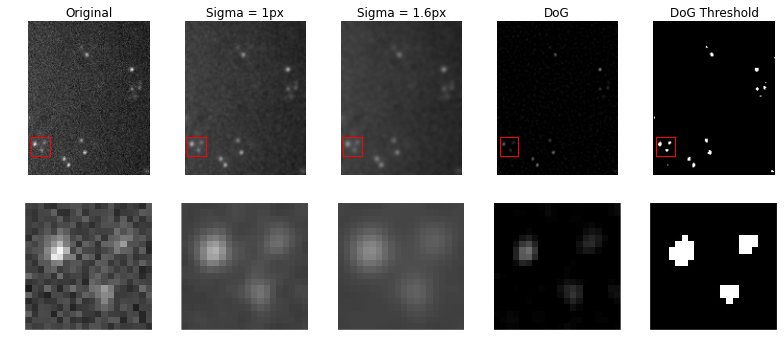

In [25]:
c_dog_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Original")
ax0.imshow(c, cmap="gray", vmin=np.min(c), vmax=np.max(c))
ax0.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax1.set_title("Sigma = 1px")
ax1.imshow(c_g1, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax1.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax2.set_title("Sigma = 1.6px")
ax2.imshow(c_g16, cmap="gray", vmin=np.min(cf), vmax=np.max(cf))
ax2.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax3.set_title("DoG")
ax3.imshow(c_dog, cmap="gray", vmin=0, vmax=0.015)
ax3.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))
ax4.set_title("DoG Threshold")
ax4.imshow(c_dog_bin, cmap="gray")
ax4.add_patch(Rectangle((c_zox, c_zoy), c_zw, c_zh, edgecolor='red', fill=False))

ax5.imshow(c[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none", vmin=np.min(c), vmax=np.max(c))
ax6.imshow(c_g1[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none", vmin=np.min(cf), vmax=np.max(cf))
ax7.imshow(c_g16[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none", vmin=np.min(cf), vmax=np.max(cf))
ax8.imshow(c_dog[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none", vmin=0, vmax=0.015)
ax9.imshow(c_dog_bin[c_zoy:c_zoy+c_zh, c_zox:c_zox+c_zw], cmap=plt.cm.gray, interpolation="none")

for ax in c_dog_plt.axes:
    ax.set_axis_off()

c_dog_plt.set_size_inches(11, 5)
plt.tight_layout()
c_dog_plt.savefig("assets/images/c_dog_lsnr.png", dpi=150, transparent=True, bbox_inches="tight")

## Watershed

In [26]:
a_g1_thresh = filters.threshold_otsu(a_g1)
a_g1_bin = a_g1 > a_g1_thresh

In [27]:
a_g1_dist = ndi.distance_transform_edt(a_g1_bin)
a_g1_peaks = peak_local_max(a_g1_dist, min_distance=4, labels=a_g1_bin,
                            indices=False)
a_g1_markers = ndi.label(a_g1_peaks)[0]
a_g1_labels = watershed(-a, a_g1_markers, mask=a_g1_bin)
a_labels_props = regionprops(a_g1_labels, intensity_image=a)

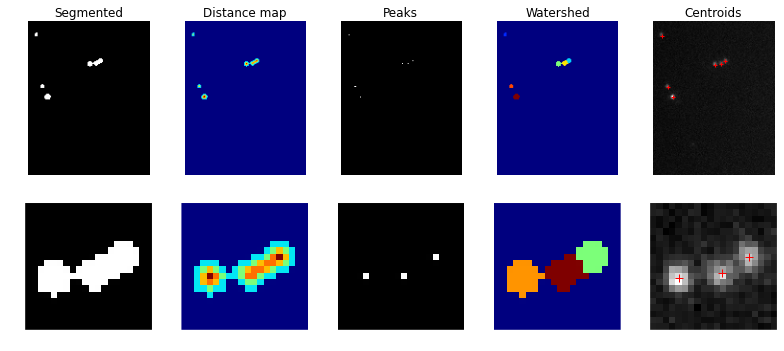

In [28]:
img_seg_plt, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(ncols=5, nrows=2)
ax0.set_title("Segmented")
ax0.imshow(a_g1_bin, cmap=plt.cm.gray)
ax1.set_title("Distance map")
ax1.imshow(a_g1_dist, cmap=plt.cm.jet)
ax2.set_title("Peaks")
ax2.imshow(a_g1_peaks, cmap=plt.cm.gray)
ax3.set_title("Watershed")
ax3.imshow(a_g1_labels, cmap=plt.cm.jet)
ax4.set_title("Centroids")
for r in a_labels_props:
    ax4.scatter(r.centroid[1], r.centroid[0], c="r", marker="+")
ax4.imshow(a, cmap='gray')

ax5.imshow(a_g1_bin[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax6.imshow(a_g1_dist[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.jet, interpolation="none")
ax7.imshow(a_g1_peaks[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax8.imshow(a_g1_labels[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.jet, interpolation="none")
for r in a_labels_props[1:4]:
    ax9.scatter(r.centroid[1]-a_zox, r.centroid[0]-a_zoy, c="r", marker="+", s=50)
ax9.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap='gray', interpolation="none")
    
for ax in img_seg_plt.axes:
    ax.axis("off")
img_seg_plt.set_size_inches(11, 5)
img_seg_plt.tight_layout()
# img_seg_plt.savefig("assets/images/img_seg_plt.png", dpi=150,transparent=True, bbox_inches="tight")

## Difference of Gaussian

In [29]:
dog = blob_dog(a, max_sigma=2, threshold=0.0015)

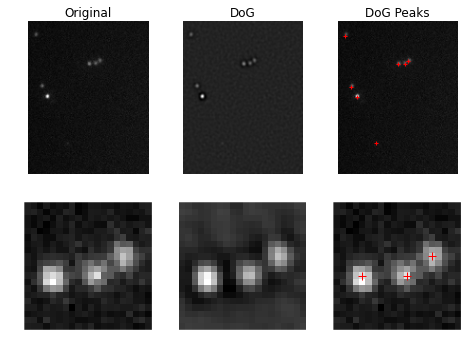

In [30]:
img_dogpeak_plt, ((ax0, ax3, ax4), (ax5, ax8, ax9)) = plt.subplots(ncols=3, nrows=2)
ax0.set_title("Original")
ax0.imshow(a, cmap="gray")
ax3.set_title("DoG")
ax3.imshow(a_dog, cmap="gray")
ax4.set_title("DoG Peaks")
ax4.scatter(x=dog[:,1], y=dog[:,0], c="r", marker=u'+')
ax4.imshow(a, cmap="gray")

ax5.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax8.imshow(a_dog[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap=plt.cm.gray, interpolation="none")
ax9.scatter(dog[1:4,1]-a_zox, dog[1:4,0]-a_zoy, c="r", marker="+", s=50)
ax9.imshow(a[a_zoy:a_zoy+a_zh, a_zox:a_zox+a_zw], cmap='gray', interpolation="none")


for ax in img_dogpeak_plt.axes:
    ax.set_axis_off()

img_dogpeak_plt.set_size_inches(6.6, 5)
plt.tight_layout()
# img_dogpeak_plt.savefig("assets/images/img_dogpeak_plt.png", dpi=150, transparent=True)

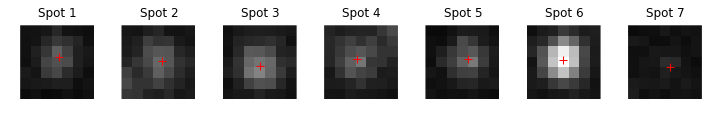

In [88]:
fits, axs = plt.subplots(ncols=len(dog))
for ((i, ax), (y, x, r), props) in zip(enumerate(axs), dog, a_dog_props):
    c_img = a[y-3:y+4,x-3:x+4]
    ax.set_title("Spot %s" % str(i+1))
    ax.axis('off')
    ax.imshow(c_img, cmap="gray", interpolation="none", vmin=np.min(a), vmax=np.max(a))
    ax.scatter(x=props.weighted_centroid[1]-(x-3), y=props.weighted_centroid[0]-(y-3), c="r", marker=u'+', s=50)

fits.set_size_inches(10, 2)
fits.tight_layout()
fits.savefig("assets/images/subpix_spots.png", dpi=150, transparent=True)

In [204]:
y, x, r = dog[0]
rad = 3
c_img = a[y-rad:y+rad+1,x-rad:x+rad+1]
sigma = 1
height = c_img.max()
b = 0.0015
params = fitgaussian(c_img, (height, rad, rad, sigma, b))
params

array([  2.04221825e+03,   2.60191464e+00,   3.08400145e+00,
         1.31445548e+00,   8.63033026e+02])

In [58]:
y, x, r = dog[0]
rad = 3
sigma = 1.6
height = c_img.max()
b = 0.0015
c_img = a[y-rad:y+rad+1,x-rad:x+rad+1]
params, infd = fitreig(c_img, (height, rad, rad, sigma, b))
params

array([  2.21704258e+04,   2.60191266e+00,   3.08400062e+00,
        -1.31445595e+00,   8.63032802e+02])

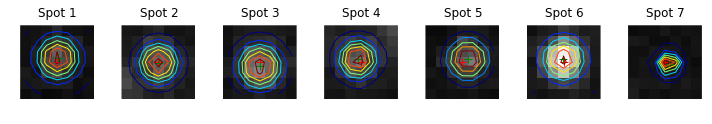

In [56]:
# Radius of 3
rad = 3
sigma = 1.6
fits, axs = plt.subplots(ncols=len(dog))
for ((i, ax), (y, x, r)) in zip(enumerate(axs), dog):
    c_img = a[y-rad:y+rad+1,x-rad:x+rad+1]
    height = c_img.max()
    b = c_img.min()
    params = fitgaussian(c_img, (height, rad, rad, sigma, b))
    gaus = gaussian(*params)
    ax.set_title("Spot %s" % str(i+1))
    ax.axis('off')
    ax.imshow(c_img, cmap="gray", interpolation="none", vmin=np.min(a), vmax=np.max(a))
    ax.scatter(x=rad, y=rad, c="r", marker=u'+', s=50)
    ax.scatter(x=params[2], y=params[1], c="g", marker=u"+", s=50)
    ax.contour(gaus(*np.indices((2*rad+1,2*rad+1))))

fits.set_size_inches(10, 2)
fits.tight_layout()
# fits.savefig("assets/images/subpix_fits.png", dpi=150, transparent=True)

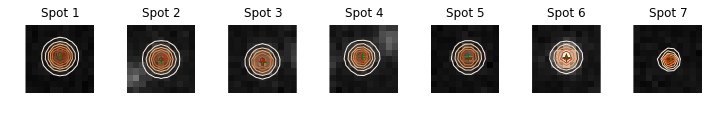

In [96]:
# Radius of 3
rad = 5
sigma = 1
fits, axs = plt.subplots(ncols=len(dog))
for ((i, ax), (y, x, r), props) in zip(enumerate(axs), dog, a_dog_props):
    c_img = a[y-rad:y+rad+1,x-rad:x+rad+1]
    height = c_img.max()
    b = c_img.min()
    params, infd = fitreig(c_img, (height, rad, rad, sigma, b))
    gaus = gaussian(*params)
    ax.set_title("Spot %s" % str(i+1))
    ax.axis('off')
    ax.imshow(c_img, cmap="gray", interpolation="none", vmin=np.min(a), vmax=np.max(a))
    ax.scatter(x=props.centroid[1]-(x-rad), y=props.centroid[0]-(y-rad), c="r", marker=u'+', s=50)
    ax.scatter(x=params[2], y=params[1], c="g", marker=u"+", s=50)
    ax.contour(gaus(*np.indices((2*rad+1,2*rad+1))), cmap=plt.cm.Oranges)

fits.set_size_inches(10, 2)
fits.tight_layout()
fits.savefig("assets/images/a_fits_r5_s1.png", dpi=150, transparent=True)